In [1]:
import numpy as np
import pandas as pd
import re
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import time
import os

import neuro_morpho_toolbox as nmt
from neuro_morpho_toolbox.flat_map import *

import sklearn
from sklearn.decomposition import PCA
import umap
from sklearn import metrics

import pickle
%matplotlib inline


/Users/pengxie/Documents/Research/python/neuro_morhpo_toolbox/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 0.58
Loading CCF brain structure data...
Loading time: 0.00
Loading flat_map ...
Loading time: 2.67


In [2]:
def sum_regions(x, region='SSp'):
    for tag in ['-ipsi', '-contra']:
        tp_list = [nmt.bs.id_to_name(i)+tag for i in nmt.bs.get_all_child_id(region)]
        tp_list = [i for i in tp_list if i in (x.columns.tolist())]
        res = x[tp_list].sum(axis=1)
        x.drop(columns=tp_list, inplace=True)
        x[region+tag] = res
    return x

## Read mesoscale data

In [3]:
mesoscale_projection_volumes = pd.read_excel('/Users/pengxie/Documents/Research/Thalamus_fullMorpho/Data/Hongkui/single cell_meso groups_source match_thresholded meso_2021-03.xlsx', 
                                          index_col=[0], sheet_name=3)
# correct some column names
mesoscale_meta = mesoscale_projection_volumes.iloc[:,:7]
# mesoscale_meta['reassigned primary-layer'] = ['-'.join(i.split('-')[:-1]) for i in mesoscale_meta['reassigned primary-layer'].tolist()]
mesoscale_projection_volumes = mesoscale_projection_volumes.iloc[:,7:]
mesoscale_projection_volumes = sum_regions(mesoscale_projection_volumes, 'SSp')

meso_list = [182616478,
263781454,
591612976,
880719308,
168002073,
266645328,
272822110,
477037203,
504105304,
518023283,
587659400,
616676552,
288169842,
294525944,
505790715,
517082898,
517313256,
517314004,
614735393,
168003640,
266486371,
560736273,
288170549,
297654263,
266644610,
298830161,
296052839,
591622344,
278317945,
303614706,
298182842,
286300594,
298106713,
303615412,
287951098,
297855879,
577773267,
288171256,
303616833,
            ]

print([i for i in meso_list if not i in mesoscale_projection_volumes.index.tolist()])
meso_list = [i for i in meso_list if i in mesoscale_projection_volumes.index.tolist()]
meso_meta_selected = mesoscale_meta.loc[meso_list].copy()

mesoscale_meta.head()

[]


,mouse-strain,dataset-name,graph-order,primary-injection-structure,secondary-injection-structures,reassigned primary-layer,Sum PV (excl fiber tracts)
image-series-id,,,,,,,
266174045,Gal-Cre_KI87,mca_classic,676,AM,AV|AD|IAD|PT,AM-,0.937515
573035760,Prkcd-GluCla-CFP-IRES-Cre,T601.3a anterograde Cre-defined EGFP,676,AM,IAM|IAD|MD|PT,AM-,1.112664
514333422,Slc17a6-IRES-Cre,T601.3a anterograde Cre-defined EGFP,676,AM,AV|AD|IAD|MD,AM-,1.397853
485903475,Gnb4-IRES2-Cre,mca_classic,557,CLA,GU|AIp|EPd|CP,CLA-,9.706556
514505957,Gnb4-IRES2-Cre,mca_classic,573,CP,SSp-m|AId|AIv|CLA,CLA-,0.132375


In [4]:
meso_meta_selected['reassigned primary-layer_full'] = meso_meta_selected['reassigned primary-layer']

regroup_dict = {'MOp-L2/3':'MOp-L2/3',
 'MOp-L5_IT':'MO-L5_IT',
 'MOs-L2/3':'MOs-L2/3',
 'MOs-L5_IT':'MO-L5_IT',
 'SSp-bfd-L2/3':'SSp-L2/3',
 'SSp-bfd-L5_IT':'SSp-L5_IT',
 'SSp-ll-L2/3':'SSp-L2/3',
 'SSp-ll-L5_IT':'SSp-L5_IT',
 'SSp-m-L2/3':'SSp-L2/3',
 'SSp-m-L5_IT':'SSp-L5_IT',
 'SSp-tr-L5_IT':'SSp-L5_IT',
 'SSp-ul-L2/3':'SSp-L2/3',
 'SSp-ul-L5_IT':'SSp-L5_IT',
 'SSs-L2/3':'SSs-L2/3',
 'SSs-L5_IT':'SSs-L5_IT'}

meso_meta_selected['reassigned primary-layer'] =  meso_meta_selected['reassigned primary-layer_full'].map(regroup_dict)

meso_meta_selected = meso_meta_selected.sort_values(['reassigned primary-layer',
                                                     'reassigned primary-layer_full'
                                                    ])

## Read single cell data

In [5]:
[ns] = pickle.load(open('./neuron_set_1741cells.pickle', 'rb'))


In [6]:
metadata = pd.read_excel('../Data/Hongkui/metadata_IT_hz2_px.xlsx', index_col=[0], sheet_name=1)
# metadata.loc[((metadata.Region.isin(['MOs', 'MOp'])) & (metadata.Layer=='4')), 'Layer'] = '5'
metadata['Region'] = [i.split('-')[0] for i in metadata['Region'].tolist()]
metadata['Layer'] = metadata['Corrected Layer']

df = metadata.copy()
ns_metadata = ns.metadata.copy()
df['Manually_corrected_soma_region'] = ns_metadata.loc[df.index, 'Manually_corrected_soma_region'].tolist()
df['Region'] = ns_metadata.loc[df.index, 'Manually_corrected_soma_region'].tolist()
df.loc[df['Region'].str.startswith('SSp'), 'Region'] = 'SSp'
df['Layer'] = ns_metadata.loc[df.index, 'Cortical_layer'].tolist()
df['Corrected Layer'] = ns_metadata.loc[df.index, 'Cortical_layer'].tolist()

df['CellType_full']=[';'.join([df.loc[i, 'Region'], 
                               'L'+str(df.loc[i, 'Layer'])
                              ]) for i in df.index.tolist()]

# swc_path = '/Users/pengxie/Documents/Research/Thalamus_fullMorpho/Data/Hanchuan/from/1523_r10_4/'
swc_path = '/Users/pengxie/Documents/Research/Thalamus_fullMorpho/Data/swc/Mapped_Feb2021/1_flip_s25/'
# swc_path = '/Users/pengxie/Documents/Research/Thalamus_fullMorpho/Data/swc/Mapped_Feb2021/3_flip_s25_resample/'
swc_list = [i for i in os.listdir(swc_path) if i.endswith('.swc')]
print('# swc files:\t%d' % (len(swc_list)))

swc_dict = dict(zip([i.split('.')[0].replace('r10_','').replace('p_', '') for i in swc_list], swc_list))

df['swc'] = [swc_dict[i] for i in df.index.tolist()]

# swc files:	1741


In [7]:
regroup_dict = {'MOp;L2/3':'MOp-L2/3',
 'MOp;L5':'MO-L5_IT',
 'MOs;L2/3':'MOs-L2/3',
 'MOs;L5':'MO-L5_IT',
 'SSp;L2/3':'SSp-L2/3',
 'SSp;L5':'SSp-L5_IT',
 'SSs;L2/3':'SSs-L2/3',
 'SSs;L5':'SSs-L5_IT'}
df = df[df['CellType_full'].isin(list(regroup_dict.keys()))]
df['CellType_full'] = df['CellType_full'].map(regroup_dict).tolist()
df['CellType_full'].value_counts()

MOp-L2/3     19
SSp-L2/3     18
MOs-L2/3     17
SSp-L5_IT    15
SSs-L2/3     11
SSs-L5_IT    10
MO-L5_IT      8
Name: CellType_full, dtype: int64

# candidate cells:	98
# non-projecting cells: 4


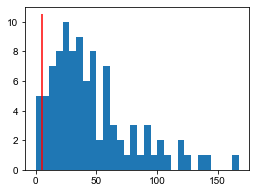

In [8]:
def dist2soma(swc, soma):
    return sklearn.metrics.pairwise_distances(swc[['x', 'y', 'z']], soma[['x', 'y', 'z']])


node_type_list = [1,2,3,4]

radius = 1000

def long_axon_arbor(cn, node_type_list=[2], radius=1000):
    csoma = cn.soma.copy()
    cseg = cn.get_segments()
    cseg['soma_distance'] = dist2soma(cseg, csoma).reshape(-1,)
    cseg = cseg[((cseg.soma_distance>radius) & (cseg.type.isin(node_type_list)))].copy()
    if len(cseg)==0:
        return 0
    return cseg['rho'].sum()
radius = 1000
thres = 5

print('# candidate cells:\t%d' % (len(df)))
df['Long_arbor(mm)'] = [long_axon_arbor(ns.neurons[i], radius=radius)/1000 for i in df.index.tolist()]

fig, ax = plt.subplots(1,1,figsize=(4,3))
_ = ax.hist(df['Long_arbor(mm)'], bins=30)

ax.vlines(x=thres, ymin=0, ymax=ax.get_ylim()[1], color='r')

print("# non-projecting cells: %d" % ((df['Long_arbor(mm)']<thres).sum()))


In [9]:
df['Long_projection'] = df['Long_arbor(mm)']>thres

In [10]:
meta_single = df.copy()
meta_single = meta_single[meta_single['Long_projection']]
meta_single = meta_single.sort_values(['CellType_full', 'Manually_corrected_soma_region'])

In [11]:
singlecell_list = meta_single.index.tolist()

In [12]:
singlecell_axon_matrix = ns.features['projection_features'].raw_data.copy().loc[singlecell_list] / 1000
singlecell_axon_matrix.drop(columns=['ipsi_fiber tracts', 'contra_fiber tracts'], inplace=True)

old_col = singlecell_axon_matrix.columns.tolist()
new_col = []
for i in old_col:
    if 'ipsi' in i:
        i = i.replace('ipsi_', '')+'-ipsi'
    else:
        i = i.replace('contra_', '')+'-contra'
    new_col.append(i)
singlecell_axon_matrix.rename(columns=dict(zip(old_col, new_col)), inplace=True)
singlecell_axon_matrix = sum_regions(singlecell_axon_matrix, 'SSp')
singlecell_axon_matrix[singlecell_axon_matrix<1] = 1
singlecell_axon_matrix = np.log(singlecell_axon_matrix)
singlecell_axon_matrix.head()

,FRP-ipsi,MOp-ipsi,MOs-ipsi,SSs-ipsi,GU-ipsi,VISC-ipsi,AUDd-ipsi,AUDp-ipsi,AUDpo-ipsi,AUDv-ipsi,...,PRM-contra,COPY-contra,PFL-contra,FL-contra,FN-contra,IP-contra,DN-contra,VeCB-contra,SSp-ipsi,SSp-contra
191812_2978_x7903_y22705,0.000000,3.654685,0.000000,0.000000,0.850459,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.851329,0.000000
191812_3163_x6264_y21524,0.047497,3.821450,3.868286,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.379602,0.000000
191812_3438_x6058_y10197,0.000000,3.395507,2.390255,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.379262,0.000000
191812_3801_x5383_y20989,0.000000,3.757811,3.077727,2.136099,0.000000,0.032381,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.498038,0.000000
191812_2734_x6259_y10487,0.000000,3.320021,3.758123,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.010448


## Combine

In [13]:
df['CellType_full'].value_counts()

MOp-L2/3     19
SSp-L2/3     18
MOs-L2/3     17
SSp-L5_IT    15
SSs-L2/3     11
SSs-L5_IT    10
MO-L5_IT      8
Name: CellType_full, dtype: int64

In [14]:
cdict = {}
rlist = ['SSp-L2/3', 'SSs-L2/3', 'SSp-L5_IT', 'SSs-L5_IT', 'MOp-L2/3', 'MOs-L2/3', 'MO-L5_IT']

clist = []
ct_list = []
exp_list = []
reg_list = []
tp_dict = {}
for i,cgroup in enumerate(rlist[:]):
    
    # mlist
    mlist = meso_meta_selected[meso_meta_selected['reassigned primary-layer']==cgroup].copy()
    mlist = mlist.sort_values(['reassigned primary-layer', 'reassigned primary-layer_full']).index.tolist()
    # slist
    if cgroup in list(cdict.keys()):
        slist = cdict[cgroup]
    else:
        slist = meta_single[meta_single['CellType_full']==cgroup].copy()
        slist = slist.sort_values(['CellType_full', 'Manually_corrected_soma_region']).index.tolist()
    
    tp_dict[cgroup+'_meso'] = mlist
    tp_dict[cgroup+'_single'] = slist
    clist = clist + mlist
    clist = clist + slist
    n = len(mlist)+len(slist)
    ct_list = ct_list + [cgroup] * n
    exp_list = exp_list + (['meso']*len(mlist) + ['single']*len(slist))
    
    # 1. select regions
    mdf = mesoscale_projection_volumes.loc[mlist].copy()
    mdf = np.log(mdf*100+1)
    sdf = singlecell_axon_matrix.loc[slist].copy()         

In [15]:
meta_single['CellType_full'].value_counts()

MOs-L2/3     17
MOp-L2/3     17
SSp-L2/3     16
SSp-L5_IT    15
SSs-L2/3     11
SSs-L5_IT    10
MO-L5_IT      8
Name: CellType_full, dtype: int64

In [16]:
meso_meta_selected.loc[meso_list, 'reassigned primary-layer'].value_counts()

MO-L5_IT     9
MOs-L2/3     8
SSp-L2/3     8
SSp-L5_IT    7
SSs-L2/3     3
MOp-L2/3     2
SSs-L5_IT    2
Name: reassigned primary-layer, dtype: int64

In [17]:
s_reg_list = ['SSp-ipsi',
 'MOp-ipsi',
 'MOs-ipsi',
 'CP-ipsi',
 'SSs-ipsi',
 'MOs-contra',
 'MOp-contra',
 'SSp-contra',
 'VISC-ipsi',
 'SSs-contra',
 'AIp-ipsi',
 'FRP-ipsi',
 'VISC-contra',
 'AId-ipsi',
 'GU-ipsi',
 'ENTl-contra',
 'CP-contra',
 'VISa-ipsi',
 'ACAd-ipsi',
 'ECT-contra',
 'EPd-ipsi',
 'FRP-contra',
 'GU-contra',
 'ENTl-ipsi',
 'VISrl-ipsi',
 'RSPagl-ipsi',
 'AIp-contra']

In [18]:
thres = 0.5
mdf = mesoscale_projection_volumes.copy()
mdf = np.log(mdf*100+1)
sdf = singlecell_axon_matrix.copy()

# res = pd.concat([sdf], axis=0)
# res = res.loc[singlecell_list]
# reg_list = (res>thres).sum(axis=0)
# reg_list = reg_list[reg_list>=5]
# reg_list = reg_list.sort_values(ascending=False).head(np.min([40, len(reg_list)])).index.tolist()
# s_reg_list = reg_list

res = pd.concat([mdf, sdf], axis=0)
res = res.loc[clist, s_reg_list]
res.shape

(133, 27)

## Heatmap

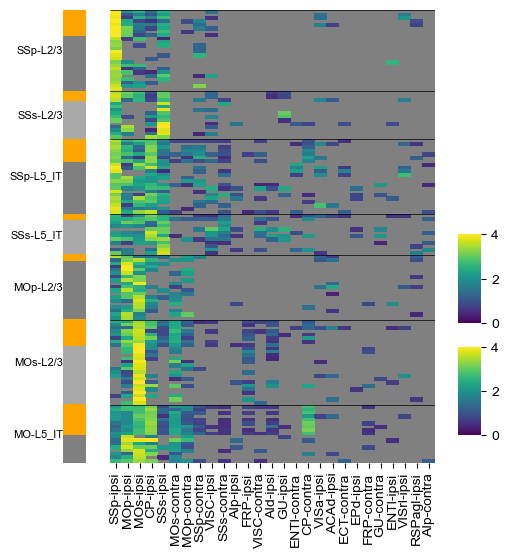

In [19]:
fig = plt.figure(1, figsize=(6,6), dpi=100)
grid = plt.GridSpec(len(res),20,wspace=0.0, hspace=0.0)

cy = 0
meso_colorbar = False
single_colorbar = False
cbar_size = int(len(res)/5)

meso_thres = 0.5
single_thres_mm = 1
single_thres = np.log(thres+1)
meso_max = 4
single_max = 4

for i, cgroup in enumerate(rlist[:]):
    hsep = False
    # mesoscale
    ctag = cgroup+'_meso'
    cn = len(tp_dict[ctag])
    if cn>0:
        ax = fig.add_subplot(grid[cy:(cy+cn),4:18])
        if not meso_colorbar:
            cbar=True
            bax = fig.add_subplot(grid[(int(len(res)/2)):(int(len(res)/2)+cbar_size),19:])
            meso_colorbar = True
        else:
            cbar=False
        ax.set_facecolor('grey')
        im=sns.heatmap(res.loc[tp_dict[ctag]],
                           cmap='viridis',
                           mask=(res.loc[tp_dict[ctag]]<meso_thres),
                           yticklabels=0,
                           xticklabels=0,
                           ax=ax,
                       vmin=0,
                       vmax=meso_max,
                           cbar=cbar,
                       cbar_ax=bax
                          )
        if not hsep:
            ax.hlines([0], *ax.get_xlim(), colors='k', lw=0.5)
            hsep = True
    cy = cy + cn
    
    # single cell
    ctag = cgroup+'_single'
    cn = len(tp_dict[ctag])
    if cn>0:
        ax = fig.add_subplot(grid[cy:(cy+cn),4:18])
        if not single_colorbar:
            cbar=True
            bax = fig.add_subplot(grid[(int(len(res)*0.75)):(int(len(res)*0.75)+cbar_size),19:])
            single_colorbar = True
        else:
            cbar=False
        ax.set_facecolor('grey')
        if cgroup == rlist[-1]:
            xticklabels = True
        else:
            xticklabels = False
        im=sns.heatmap(res.loc[tp_dict[ctag]],
                           cmap='viridis',
                           mask=(res.loc[tp_dict[ctag]]<single_thres),
                           yticklabels=0,
                           xticklabels=xticklabels,
                           ax=ax,
                       vmin=0,
                       vmax=single_max,
                           cbar=cbar,
                       cbar_ax=bax
                          )
        if not hsep:
            ax.hlines([0], *ax.get_xlim(), colors='k', lw=0.5)
            hsep = True
    cy = cy + cn    



rax = fig.add_subplot(grid[:,:2])
h_0 = 1
h_unit = 1/len(res)
for i in rlist:
    n = ct_list.count(i)
    h_0 = h_0 - h_unit*n
    if n>0:
        rax.text(1,h_0+h_unit*n/2, i, fontdict={'size':8, 'ha':'right', 'va':'center'})
rax.axis('off')
# rax.hlines(1-np.array(sep_list)/len(res), xmin=0.9, xmax=1, colors='k', lw=0.5)
rax.set_xlim((0,1))
rax.set_ylim((0,1))

rax = fig.add_subplot(grid[:,2:3])
row_colors = pd.DataFrame({'Region':ct_list, 'Meso/Single':exp_list}, index=res.index)
lut = dict(zip(row_colors['Region'].unique(), [0, 1]*100))
row_colors['Region'] = row_colors['Region'].map(lut)
row_colors.loc[row_colors['Meso/Single']=='meso', 'Region'] = 3

# lut = dict(zip(row_colors['Meso/Single'].unique(), "rb"*100))
# row_colors['Meso/Single'] = row_colors['Meso/Single'].map(lut)

im=sns.heatmap(row_colors[['Region']],
                   cmap=['grey', 'darkgrey', 'orange'],
                   ax=rax,
                   yticklabels=0,
                   xticklabels=0,
#                row_colors=row_colors
                   cbar=False
                  )

fig.savefig('../Figure/CTX_L2-5_IT_projection_matrix_singlecell.pdf', bbox_inches='tight')

## Make figures separately for each region

In [20]:
combine_meta = meso_meta_selected[['reassigned primary-layer']].copy()
combine_meta.rename(columns={'reassigned primary-layer':'CellType_full'}, inplace=True)
combine_meta = pd.concat([combine_meta, meta_single[['CellType_full']]], axis=0)

combine_meta

,CellType_full
591612976,MO-L5_IT
880719308,MO-L5_IT
288169842,MO-L5_IT
294525944,MO-L5_IT
505790715,MO-L5_IT
...,...
191812_3762_x9097_y24261,SSs-L5_IT
191812_4664_x8027_y25176,SSs-L5_IT
191812_5158_x9017_y25877,SSs-L5_IT
191812_5221_x9028_y25900,SSs-L5_IT


In [21]:
meso_meta_selected.head()

,mouse-strain,dataset-name,graph-order,primary-injection-structure,secondary-injection-structures,reassigned primary-layer,Sum PV (excl fiber tracts),reassigned primary-layer_full
image-series-id,,,,,,,,
591612976,Tlx3-Cre_PL56,mca_classic,18,MOp,MOs,MO-L5_IT,2.568834,MOp-L5_IT
880719308,Tlx3-Cre_PL56,mca_classic,18,MOp,0,MO-L5_IT,2.887843,MOp-L5_IT
288169842,Tlx3-Cre_PL56,mca_classic,24,MOs,NaN,MO-L5_IT,2.701226,MOs-L5_IT
294525944,Tlx3-Cre_PL56,mca_classic,24,MOs,NaN,MO-L5_IT,4.143837,MOs-L5_IT
505790715,Tlx3-Cre_PL56,T504 Connectivity Mapping,24,MOs,NaN,MO-L5_IT,3.833373,MOs-L5_IT


In [22]:
meta_single.head()

,Registration_Region,Region,Suggested_region,Layer,CreLine,Brain,Yun_celltype,Long_projection,Corrected Layer,HZ comments,HZ comments v2,HZ comments v2.1,Manually_corrected_soma_region,CellType_full,swc,Long_arbor(mm)
191812_2978_x7903_y22705,MOp,MOp,MOp,5,Plxnd1,191812,NaN,True,5,For Fig 5g and Fig 6e-f,Fig 5,NaN,MOp,MO-L5_IT,191812_2978_x7903_y22705.auto_r.swc,21.207958
191812_3163_x6264_y21524,MOp,MOp,MOp,5,Plxnd1,191812,NaN,True,5,For Fig 5g and Fig 6e-f,Fig 5,Fig 5a,MOp,MO-L5_IT,191812_3163_x6264_y21524.auto_r.swc,167.152109
191812_3438_x6058_y10197,MOp,MOp,MOp,5,Plxnd1,191812,NaN,True,5,For Fig 5g and Fig 6e-f,Fig 5,Fig 5a,MOp,MO-L5_IT,191812_3438_x6058_y10197.auto_r.swc,32.294832
191812_3801_x5383_y20989,MOp,MOp,MOp,5,Plxnd1,191812,NaN,True,5,For Fig 5g and Fig 6e-f,Fig 5,Fig 5a,MOp,MO-L5_IT,191812_3801_x5383_y20989.auto_r.swc,100.847360
191812_2734_x6259_y10487,MOs,MOs,MOs,5,Plxnd1,191812,NaN,True,5,NaN,Fig 5,Fig 5a,MOs,MO-L5_IT,191812_2734_x6259_y10487.auto_r.swc,52.758429


### 1. SSp

In [23]:
mdf = mesoscale_projection_volumes.copy()
mdf_max = pd.DataFrame(columns=mdf.columns)
meso_meta_selected_max = pd.DataFrame(columns=['reassigned primary-layer'])
ugroups = meso_meta_selected['reassigned primary-layer'].unique().tolist()
for i in ugroups:
    tlist = meso_meta_selected[meso_meta_selected['reassigned primary-layer']==i].index
    print('%s:\t%d' % (i, len(tlist)))
    tp = np.array(mdf.loc[tlist].max(axis=0).tolist()).reshape(1,-1)
    tp = pd.DataFrame(tp, index=['meso_max_'+i], columns=mdf.columns)
    mdf_max = pd.concat([mdf_max, tp], axis=0)
    tp = pd.DataFrame([i], index=['meso_max_'+i], columns=['reassigned primary-layer'])
    meso_meta_selected_max = pd.concat([meso_meta_selected_max, tp], axis=0)

MO-L5_IT:	9
MOp-L2/3:	2
MOs-L2/3:	8
SSp-L2/3:	8
SSp-L5_IT:	7
SSs-L2/3:	3
SSs-L5_IT:	2


In [24]:
meso_meta_selected_max['reassigned primary-layer']

meso_max_MO-L5_IT      MO-L5_IT
meso_max_MOp-L2/3      MOp-L2/3
meso_max_MOs-L2/3      MOs-L2/3
meso_max_SSp-L2/3      SSp-L2/3
meso_max_SSp-L5_IT    SSp-L5_IT
meso_max_SSs-L2/3      SSs-L2/3
meso_max_SSs-L5_IT    SSs-L5_IT
Name: reassigned primary-layer, dtype: object

# targets:	40
33
SSp-L2/3
6 3.3125
SSp-L5_IT
20 11.8


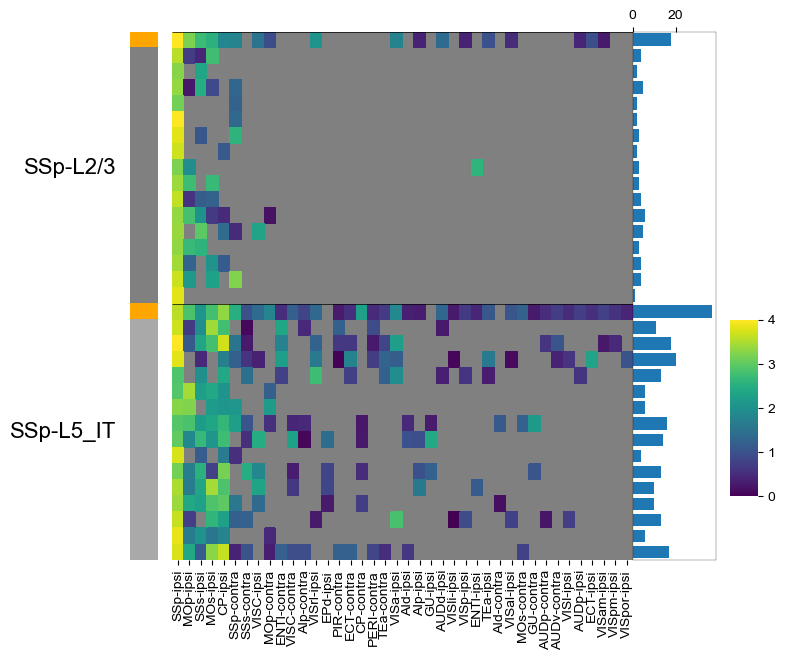

In [25]:
def heatmap_by_groups(rlist, group_name, primary_target, thres_meso = 0.1, thres_single_mm = 1, figsize=(8,4)):
    thres_single_log = np.log(thres_single_mm)
    # Select experiments
    cdict = {}
    
    clist = []
    ct_list = []
    exp_list = []
    reg_list = []
    tp_dict = {}
    for i,cgroup in enumerate(rlist[:]):

        # mlist
        mlist = meso_meta_selected_max[meso_meta_selected_max['reassigned primary-layer']==cgroup].index.tolist()
        # slist
        if cgroup in list(cdict.keys()):
            slist = cdict[cgroup]
        else:
            slist = meta_single[meta_single['CellType_full']==cgroup].copy()
            slist = slist.sort_values(['CellType_full', 'Manually_corrected_soma_region']).index.tolist()

        tp_dict[cgroup+'_meso'] = mlist
        tp_dict[cgroup+'_single'] = slist
        clist = clist + mlist
        clist = clist + slist
        n = len(mlist)+len(slist)
        ct_list = ct_list + [cgroup] * n
        exp_list = exp_list + (['meso']*len(mlist) + ['single']*len(slist))
    
    mlist = [i for i in clist if i in meso_meta_selected_max.index]
    slist = [i for i in clist if i in meta_single.index]
    
    # Select regions
    mdf = mdf_max.copy().loc[mlist]
    mdf = np.log(mdf*100+1)
    sdf = singlecell_axon_matrix.copy().loc[slist]

    res = pd.concat([sdf], axis=0)
    reg_list = (res>thres_single_log).sum(axis=0)
    reg_list = reg_list[reg_list>=1]
    reg_list = reg_list.sort_values(ascending=False).head(np.min([40, len(reg_list)])).index.tolist()
    s_reg_list = reg_list

    # Make figure
    # Put the source region at first
    if primary_target in s_reg_list:
        s_reg_list.remove(primary_target)
    s_reg_list = [primary_target] + s_reg_list
    print('# targets:\t%d' % len(s_reg_list))

    res = pd.concat([mdf, sdf], axis=0)
    res = res.loc[clist, s_reg_list]

    fig = plt.figure(1, figsize=figsize, dpi=100)
    grid = plt.GridSpec(len(ct_list),50,wspace=0.0, hspace=0.0)

    cy = 0
    meso_colorbar = False
    single_colorbar = False
    cbar_size = int(len(res)/3)

    ## Part 1: side bar
    rax = fig.add_subplot(grid[:,:4])
    h_0 = 1
    h_unit = 1/len(res)
    for i in rlist:
        n = ct_list.count(i)
        h_0 = h_0 - h_unit*n
        if n>0:
            rax.text(1,h_0+h_unit*n/2, i, fontdict={'size':16, 'ha':'right', 'va':'center'})
    rax.axis('off')
    # rax.hlines(1-np.array(sep_list)/len(res), xmin=0.9, xmax=1, colors='k', lw=0.5)
    rax.set_xlim((0,1))
    rax.set_ylim((0,1))

    rax = fig.add_subplot(grid[:,5:7])
    row_colors = pd.DataFrame({'Region':ct_list, 'Meso/Single':exp_list})
    lut = dict(zip(row_colors['Region'].unique(), [0, 1]*100))
    row_colors['Region'] = row_colors['Region'].map(lut)
    row_colors.loc[row_colors['Meso/Single']=='meso', 'Region'] = 3

    # lut = dict(zip(row_colors['Meso/Single'].unique(), "rb"*100))
    # row_colors['Meso/Single'] = row_colors['Meso/Single'].map(lut)

    im=sns.heatmap(row_colors[['Region']],
                       cmap=['grey', 'darkgrey', 'orange'],
                       ax=rax,
                       yticklabels=0,
                       xticklabels=0,
    #                row_colors=row_colors
                       cbar=False
                      )

    ## Part 2: projection matrix & color bar
    meso_thres = thres_meso
    single_thres = thres_single_log
    single_max = 4
    meso_max = single_max

    # exp_list = []
    for i, cgroup in enumerate(rlist[:]):
        hsep = False
        # mesoscale
        ctag = cgroup+'_meso'
#         cn = len(tp_dict[ctag])
        cn = 1
    #     exp_list = exp_list + tp_dict[ctag]
        if cn>0:
            ax = fig.add_subplot(grid[cy:(cy+cn),8:41])
#             if not meso_colorbar:
#                 cbar=True
#                 bax = fig.add_subplot(grid[(int(len(res)/2)):(int(len(res)/2)+cbar_size),49:])
#                 meso_colorbar = True
#             else:
#                 cbar=False
            cbar = False
            ax.set_facecolor('grey')
            pdf_meso = pd.DataFrame(np.array(res.loc[tp_dict[ctag]].max(axis=0)).reshape(1,-1))
            im=sns.heatmap(pdf_meso,
                               cmap='viridis',
                               mask=(pdf_meso<meso_thres),
                               yticklabels=0,
                               xticklabels=0,
                               ax=ax,
                           vmin=0,
                           vmax=meso_max,
                               cbar=cbar,
#                            cbar_ax=bax
                              )
            if not hsep:
                ax.hlines([0], *ax.get_xlim(), colors='k', lw=0.5)
                hsep = True
        cy = cy + cn

        # single cell
        ctag = cgroup+'_single'
        cn = len(tp_dict[ctag])
        if cn>0:
            ax = fig.add_subplot(grid[cy:(cy+cn),8:41])
            if not single_colorbar:
                cbar=True
                bax = fig.add_subplot(grid[(int(len(ct_list)*0.55)):(int(len(ct_list)*0.55)+cbar_size),48:])
                single_colorbar = True
            else:
                cbar=False
            ax.set_facecolor('grey')
            if cgroup == rlist[-1]:
                xticklabels = True
            else:
                xticklabels = False
            im=sns.heatmap(res.loc[tp_dict[ctag]],
                               cmap='viridis',
                               mask=(res.loc[tp_dict[ctag]]<=single_thres),
                               yticklabels=0,
                               xticklabels=xticklabels,
                               ax=ax,
                           vmin=0,
                           vmax=single_max,
                               cbar=cbar,
                           cbar_ax=bax
                              )
            if not hsep:
                ax.hlines([0], *ax.get_xlim(), colors='k', lw=0.5)
                hsep = True
        cy = cy + cn    

    print(len(clist))
    ## Part 3: histogram
    hax = fig.add_subplot(grid[:,41:47])
    hdata = res[s_reg_list].copy()
    hdata.loc[mlist] = hdata.loc[mlist]>meso_thres 
    hdata.loc[slist] = hdata.loc[slist]>single_thres 
    hdata = hdata.sum(axis=1)
    ys = np.linspace(0.5, len(hdata)-0.5, len(hdata))
    hax.barh(y=ys, width=hdata)
    hax.set_ylim((len(hdata), 0))
    hax.set_yticks([])
    for i in rlist:
        tp_list = combine_meta[combine_meta['CellType_full']==i].index.tolist()
        tp_list = [j for j in tp_list if j in slist]
        print(i)
        print(hdata.loc[tp_list].max(), hdata.loc[tp_list].mean())
    for axis in ['top','bottom','left','right']:
        hax.spines[axis].set_linewidth(0.2)
    hax.xaxis.set_ticks_position("top")

    fig.savefig('../Figure/%s_L2-5_IT_projection_matrix.pdf' % (group_name), bbox_inches='tight')
    return hdata

rlist = ['SSp-L2/3', 'SSp-L5_IT']
group_name = 'SSp'
primary_target = 'SSp-ipsi'
thres_meso = 0.2

n_targets_SSp = heatmap_by_groups(rlist, group_name, primary_target, thres_meso=thres_meso, figsize=(9,7))

# targets:	40
23
SSs-L2/3
10 5.363636363636363
SSs-L5_IT
19 12.0


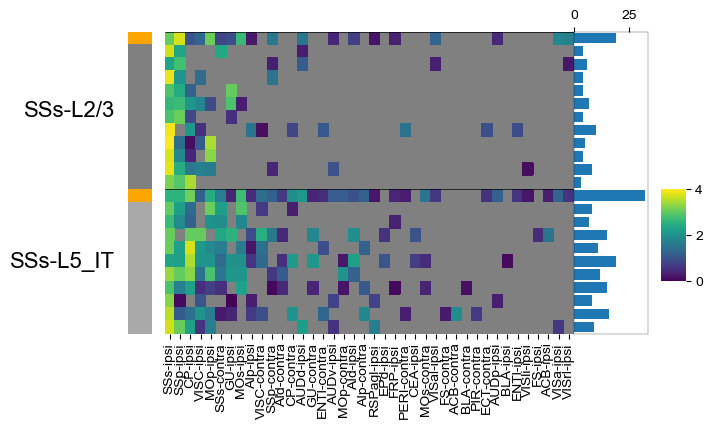

In [26]:
rlist = ['SSs-L2/3', 'SSs-L5_IT']
group_name = 'SSs'
primary_target = 'SSs-ipsi'
thres_meso = 0.1

n_targets_SSs = heatmap_by_groups(rlist, group_name, primary_target, thres_meso=thres_meso)

# targets:	40
45
MOp-L2/3
12 6.0
MOs-L2/3
11 7.0
MO-L5_IT
13 8.5


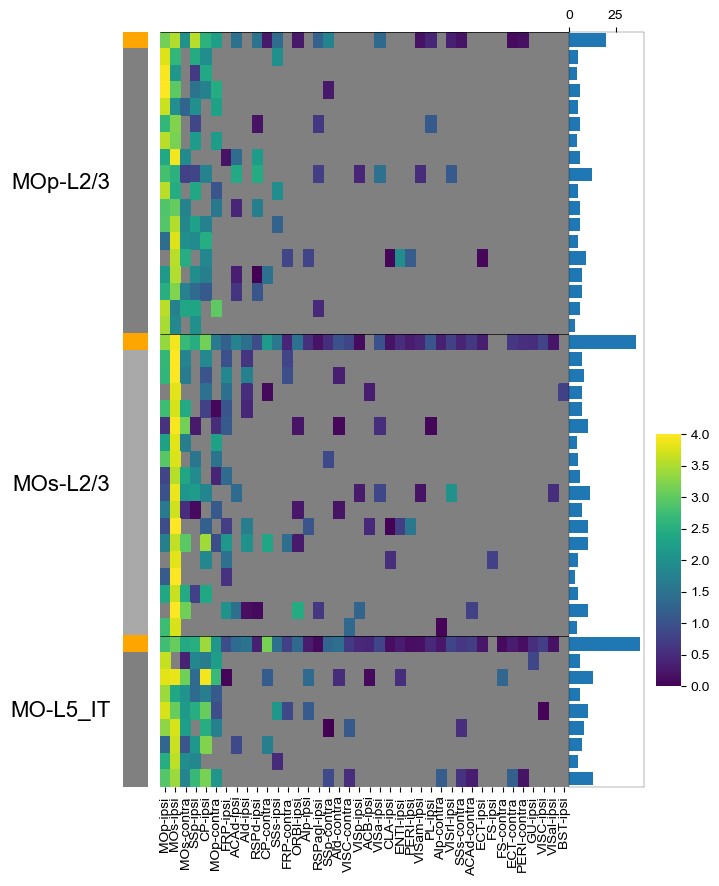

In [27]:
rlist = ['MOp-L2/3', 'MOs-L2/3', 'MO-L5_IT']
group_name = 'MO'
primary_target = 'MOp-ipsi'
thres_meso = 0.1

n_targets_MO = heatmap_by_groups(rlist, group_name, primary_target, thres_meso=thres_meso, figsize=(8,10))

In [28]:
'''
Quantitative comparison of the difference between L2/3 IT and L5 IT cells, 
including total number of targets, total axon length, axon length in ipsilateral or contralateral cortex, 
axon length in ipsilateral or contralateral CP, etc. Do this for MOs/MOp, SSp and SSs separately.
'''

'\nQuantitative comparison of the difference between L2/3 IT and L5 IT cells, \nincluding total number of targets, total axon length, axon length in ipsilateral or contralateral cortex, \naxon length in ipsilateral or contralateral CP, etc. Do this for MOs/MOp, SSp and SSs separately.\n'

In [29]:
fdata = meta_single.copy()
fdata['N_targets'] = 0
fdata['Total_axon_length'] = 0
fdata['Total_axon_length_ipsi'] = 0
fdata['Total_axon_length_contra'] = 0
fdata['Total_axon_length_CP_ipsi'] = 0
fdata['Total_axon_length_CP_contra'] = 0
fdata['Group_name'] = ''
fdata['Layer'] = [i.split('-')[1] for i in fdata['CellType_full'].tolist()]

In [30]:
rdict = {'SSp':['SSp-L2/3', 'SSp-L5_IT'],
         'SSs':['SSs-L2/3', 'SSs-L5_IT'],
         'MO':['MOp-L2/3', 'MOs-L2/3', 'MO-L5_IT'],
        }
for i in list(rdict.keys()):
    fdata.loc[fdata['CellType_full'].isin(rdict[i]), 'Group_name'] = i

In [32]:
for cdf in [n_targets_SSp, n_targets_SSs, n_targets_MO]:
    tlist = [i for i in cdf.index if i in fdata.index]
    fdata.loc[tlist, 'N_targets'] = cdf.loc[tlist].tolist()

In [35]:
tp = fdata[fdata['CreLine']=='Cux2'].copy()
tp['CellType_full'].value_counts()

MOp-L2/3    17
MOs-L2/3    17
SSp-L2/3    16
SSs-L2/3    11
Name: CellType_full, dtype: int64

In [61]:
def get_segments(swc):
    # lab = [i for i,name in enumerate(swc.index.tolist()) if swc.loc[name, "parent"]!=(-1)]
    # child = swc[swc.parent != (-1)]
    child = swc[swc.parent.isin(swc.index)]
    parent = swc.loc[child.parent]
    rho, theta, phi = nmt.cart2pol_3d(np.array(child[["x", "y", "z"]]) - np.array(parent[["x", "y", "z"]]))
    res = pd.DataFrame({"type": child.type,
                        "rho": rho,
                        "theta": theta,
                        "phi": phi,
                        "x": (np.array(child.x) + np.array(parent.x)) / 2,
                        "y": (np.array(child.y) + np.array(parent.y)) / 2,
                        "z": (np.array(child.z) + np.array(parent.z)) / 2
                        })
    res.index = range(1, len(child)+1)
    # soma
    soma = swc[((swc.type==1) & (swc.parent==-1))]
    if len(soma)>0:
        soma_res = pd.DataFrame({"type": 1,
                                 "rho": 1,
                                 "theta": 0,
                                 "phi": 0,
                                 "x": soma.x.iloc[0],
                                 "y": soma.y.iloc[0],
                                 "z": soma.z.iloc[0]},
                                index=[0])
        res = soma_res.append(res)
    return res

midline = nmt.annotation.micron_size['z']/2
def get_axon_length(cname, side=None):
    swc = ns.neurons[cname].swc.copy()
    swc = swc[swc['type']==2]
    if not side is None:
        if side == 'ipsilateral':
            swc = swc[swc['z']<midline]
        if side == 'contralateral':
            swc = swc[swc['z']>midline]
    res = get_segments(swc)['rho'].sum()/1000
    return res

get_axon_length(tlist[0], side='ipsilateral')

87.7281636731977

In [62]:
ctx_names = [nmt.bs.id_to_name(i) for i in nmt.bs.get_all_child_id('CTX') if i in nmt.bs.selected_regions]
ctx_ipsi = ['ipsi_'+i for i in ctx_names]
ctx_contra = ['contra_'+i for i in ctx_names]

In [63]:
fdata['Total_axon_length'] = 0
fdata['Total_axon_length_ipsi'] = 0
fdata['Total_axon_length_contra'] = 0
fdata['Total_axon_length_CP_ipsi'] = 0
fdata['Total_axon_length_CP_contra'] = 0

for cname in fdata.index:
    fdata.loc[cname, 'Total_axon_length'] = get_axon_length(cname)
    fdata.loc[cname, 'Total_axon_length_ipsi'] = ns.features['projection_features'].raw_data.loc[cname, ctx_ipsi].sum()/1000
    fdata.loc[cname, 'Total_axon_length_contra'] = ns.features['projection_features'].raw_data.loc[cname, ctx_contra].sum()/1000
    fdata.loc[cname, 'Total_axon_length_CP_ipsi'] = ns.features['projection_features'].raw_data.loc[cname, 'ipsi_CP']/1000
    fdata.loc[cname, 'Total_axon_length_CP_contra'] = ns.features['projection_features'].raw_data.loc[cname, 'contra_CP']/1000
    

In [68]:
order_list = ['SSp-L2/3', 'SSp-L5_IT', 'SSs-L2/3', 'SSs-L5_IT', 'MOp-L2/3', 'MOs-L2/3', 'MO-L5_IT']

In [70]:
from scipy.stats import mannwhitneyu
measure = 'N_targets'
_, pv = mannwhitneyu(fdata[fdata['CellType_full']=='SSp-L2/3'][measure],
             fdata[fdata['CellType_full']=='SSp-L5_IT'][measure]
            )

In [78]:
ct_pairs = [['SSp-L2/3', 'SSp-L5_IT'],
            ['SSs-L2/3', 'SSs-L5_IT'], 
            ['MOp-L2/3', 'MOs-L2/3'],
            ['MOp-L2/3', 'MO-L5_IT'],
            ['MOs-L2/3', 'MO-L5_IT'],
           ]
def get_pv(measure):
    print(measure)
    for cpair in ct_pairs:
        ct1 = cpair[0]
        ct2 = cpair[1]
        _, pv = mannwhitneyu(fdata[fdata['CellType_full']==ct1][measure],
                             fdata[fdata['CellType_full']==ct2][measure]
                            )
        print('%s : %s\t%.2e' % (ct1, ct2, pv))
    return

measure_list = ['N_targets', 
               'Total_axon_length', 
               'Total_axon_length_ipsi',
               'Total_axon_length_contra', 
               'Total_axon_length_CP_ipsi',
               'Total_axon_length_CP_contra']
for measure in measure_list:
    get_pv(measure)

N_targets
SSp-L2/3 : SSp-L5_IT	3.53e-06
SSs-L2/3 : SSs-L5_IT	3.26e-04
MOp-L2/3 : MOs-L2/3	1.08e-01
MOp-L2/3 : MO-L5_IT	1.73e-02
MOs-L2/3 : MO-L5_IT	1.51e-01
Total_axon_length
SSp-L2/3 : SSp-L5_IT	5.23e-06
SSs-L2/3 : SSs-L5_IT	1.33e-02
MOp-L2/3 : MOs-L2/3	1.01e-01
MOp-L2/3 : MO-L5_IT	6.13e-02
MOs-L2/3 : MO-L5_IT	2.16e-01
Total_axon_length_ipsi
SSp-L2/3 : SSp-L5_IT	1.52e-05
SSs-L2/3 : SSs-L5_IT	4.58e-01
MOp-L2/3 : MOs-L2/3	1.43e-01
MOp-L2/3 : MO-L5_IT	3.31e-01
MOs-L2/3 : MO-L5_IT	4.88e-01
Total_axon_length_contra
SSp-L2/3 : SSp-L5_IT	2.52e-04
SSs-L2/3 : SSs-L5_IT	5.07e-03
MOp-L2/3 : MOs-L2/3	1.94e-01
MOp-L2/3 : MO-L5_IT	1.06e-02
MOs-L2/3 : MO-L5_IT	6.83e-02
Total_axon_length_CP_ipsi
SSp-L2/3 : SSp-L5_IT	7.77e-07
SSs-L2/3 : SSs-L5_IT	1.58e-02
MOp-L2/3 : MOs-L2/3	5.00e-01
MOp-L2/3 : MO-L5_IT	1.05e-02
MOs-L2/3 : MO-L5_IT	1.00e-02
Total_axon_length_CP_contra
SSp-L2/3 : SSp-L5_IT	4.74e-03
SSs-L2/3 : SSs-L5_IT	7.69e-02
MOp-L2/3 : MOs-L2/3	1.62e-01
MOp-L2/3 : MO-L5_IT	3.07e-02
MOs-L2/3 : MO-L5_

In [69]:
hue_dict = {'SSp-L2/3':'C0', 
            'SSp-L5_IT':'C1', 
            'SSs-L2/3':'C0', 
            'SSs-L5_IT':'C1', 
            'MOp-L2/3':'C0', 
            'MOs-L2/3':'C2', 
            'MO-L5_IT':'C1'}

group_hue = {'SSp':['C0', 'C1'],
             'SSs':['C0', 'C1'],
             'MO':['C0', 'C2', 'C1']
            }

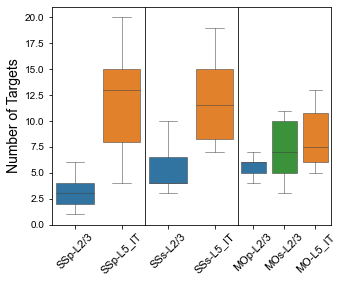

In [48]:
fig,ax = plt.subplots(1,3,figsize=(5,4), sharey=False)
plt.subplots_adjust(wspace=0)
ax = ax.reshape(-1,)
measure = 'N_targets'
for i,cgroup in enumerate(['SSp', 'SSs', 'MO']):
    pdata = fdata[fdata['Group_name']==cgroup].copy()
    cax = ax[i]
    
    sns.boxplot(x='CellType_full', 
                y=measure, 
#                 hue='CellType_full',
                palette=group_hue[cgroup],
                order=rdict[cgroup], 
                data = pdata, 
                ax=cax, 
                linewidth=0.5,
                showfliers=False)
    cax.set_xlabel('')
    if i>0:
        cax.set_ylabel('')
        cax.set_yticks([])
    else:
        cax.set_ylabel('Number of Targets', fontdict={'fontsize':14})
    cax.set_ylim(0,21)
    cax.set_xticklabels(rdict[cgroup], fontdict={'rotation':45, 'fontsize':11})
    
fig.savefig('../Figure/IT_comparison_N_targets.pdf', bbox_inches='tight')

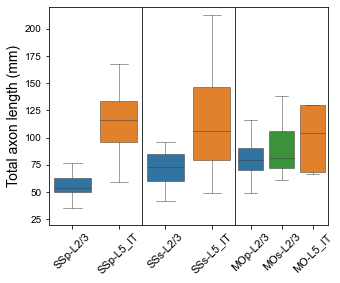

In [73]:
fig,ax = plt.subplots(1,3,figsize=(5,4), sharey=False)
plt.subplots_adjust(wspace=0)
ax = ax.reshape(-1,)
for i,cgroup in enumerate(['SSp', 'SSs', 'MO']):
    pdata = fdata[fdata['Group_name']==cgroup].copy()
    cax = ax[i]
    sns.boxplot(x='CellType_full', 
                y='Total_axon_length', 
#                 hue='Layer',
                palette=group_hue[cgroup],
                order=rdict[cgroup], 
                data = pdata, 
                ax=cax, 
                linewidth=0.5,
                showfliers=False)
    cax.set_xlabel('')
    if i>0:
        cax.set_ylabel('')
        cax.set_yticks([])
    else:
        cax.set_ylabel('Total axon length (mm)', fontdict={'fontsize':14})
    cax.set_ylim(20,220)
    cax.set_xticklabels(rdict[cgroup], fontdict={'rotation':45, 'fontsize':11})
    
fig.savefig('../Figure/IT_comparison_total_length.pdf', bbox_inches='tight')

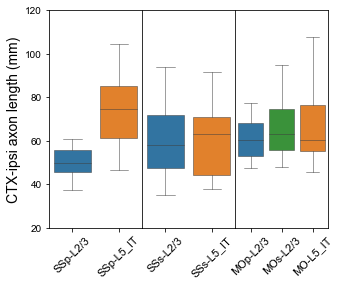

In [74]:
fig,ax = plt.subplots(1,3,figsize=(5,4), sharey=False)
plt.subplots_adjust(wspace=0)
ax = ax.reshape(-1,)
for i,cgroup in enumerate(['SSp', 'SSs', 'MO']):
    pdata = fdata[fdata['Group_name']==cgroup].copy()
    cax = ax[i]
    sns.boxplot(x='CellType_full', 
                y='Total_axon_length_ipsi', 
#                 hue='Layer',
                order=rdict[cgroup], 
                palette=group_hue[cgroup],
                data = pdata, 
                ax=cax, 
                linewidth=0.5,
                showfliers=False)
    cax.set_xlabel('')
    if i>0:
        cax.set_ylabel('')
        cax.set_yticks([])
    else:
        cax.set_ylabel('CTX-ipsi axon length (mm)', fontdict={'fontsize':14})
    cax.set_ylim(20,120)
    cax.set_xticklabels(rdict[cgroup], fontdict={'rotation':45, 'fontsize':11})
    
fig.savefig('../Figure/IT_comparison_total_length_ipsi.pdf', bbox_inches='tight')

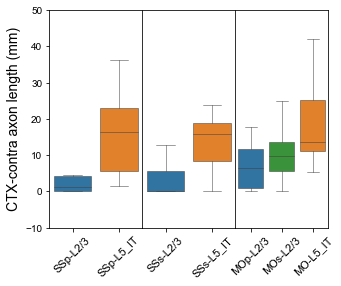

In [75]:
fig,ax = plt.subplots(1,3,figsize=(5,4), sharey=False)
plt.subplots_adjust(wspace=0)
ax = ax.reshape(-1,)
for i,cgroup in enumerate(['SSp', 'SSs', 'MO']):
    pdata = fdata[fdata['Group_name']==cgroup].copy()
    cax = ax[i]
    sns.boxplot(x='CellType_full', 
                y='Total_axon_length_contra', 
#                 hue='Layer',
                order=rdict[cgroup], 
                palette=group_hue[cgroup],
                data = pdata, 
                ax=cax, 
                linewidth=0.5,
                showfliers=False)
    cax.set_xlabel('')
    if i>0:
        cax.set_ylabel('')
        cax.set_yticks([])
    else:
        cax.set_ylabel('CTX-contra axon length (mm)', fontdict={'fontsize':14})
    cax.set_ylim(-10,50)
    cax.set_xticklabels(rdict[cgroup], fontdict={'rotation':45, 'fontsize':11})
    
fig.savefig('../Figure/IT_comparison_total_length_contra.pdf', bbox_inches='tight')

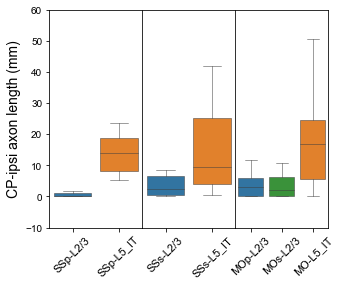

In [76]:
fig,ax = plt.subplots(1,3,figsize=(5,4), sharey=False)
plt.subplots_adjust(wspace=0)
ax = ax.reshape(-1,)
for i,cgroup in enumerate(['SSp', 'SSs', 'MO']):
    pdata = fdata[fdata['Group_name']==cgroup].copy()
    cax = ax[i]
    sns.boxplot(x='CellType_full', 
                y='Total_axon_length_CP_ipsi', 
#                 hue='Layer',
                order=rdict[cgroup], 
                palette=group_hue[cgroup],
                data = pdata, 
                ax=cax, 
                linewidth=0.5,
                showfliers=False)
    cax.set_xlabel('')
    if i>0:
        cax.set_ylabel('')
        cax.set_yticks([])
    else:
        cax.set_ylabel('CP-ipsi axon length (mm)', fontdict={'fontsize':14})
    cax.set_ylim(-10,60)
    cax.set_xticklabels(rdict[cgroup], fontdict={'rotation':45, 'fontsize':11})
    
fig.savefig('../Figure/IT_comparison_total_length_ipsi_CP.pdf', bbox_inches='tight')

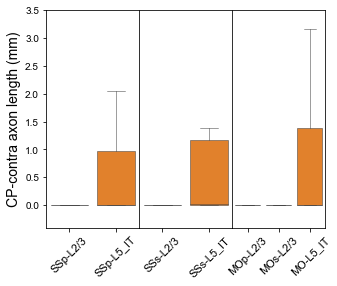

In [77]:
fig,ax = plt.subplots(1,3,figsize=(5,4), sharey=False)
plt.subplots_adjust(wspace=0)
ax = ax.reshape(-1,)
for i,cgroup in enumerate(['SSp', 'SSs', 'MO']):
    pdata = fdata[fdata['Group_name']==cgroup].copy()
    cax = ax[i]
    sns.boxplot(x='CellType_full', 
                y='Total_axon_length_CP_contra', 
#                 hue='Layer',
                order=rdict[cgroup], 
                palette=group_hue[cgroup],
                data = pdata, 
                ax=cax, 
                linewidth=0.5,
                showfliers=False)
    cax.set_xlabel('')
    if i>0:
        cax.set_ylabel('')
        cax.set_yticks([])
    else:
        cax.set_ylabel('CP-contra axon length (mm)', fontdict={'fontsize':14})
    cax.set_ylim(-0.4,3.5)
    cax.set_xticklabels(rdict[cgroup], fontdict={'rotation':45, 'fontsize':11})
    
fig.savefig('../Figure/IT_comparison_total_length_contra_CP.pdf', bbox_inches='tight')

## Count number of targets for Fig 2a

In [38]:
sorted(meta_single['CellType_full'].unique().tolist())

['MO-L5_IT',
 'MOp-L2/3',
 'MOs-L2/3',
 'SSp-L2/3',
 'SSp-L5_IT',
 'SSs-L2/3',
 'SSs-L5_IT']

In [ ]:
rlist = ['SSp-L2/3', 'SSp-L2/3', 'SSp-L5_IT']
group_name = 'SSp'
primary_target = 'SSp-ipsi'
thres_meso = 0.2

n_targets_SSp = heatmap_by_groups(rlist, group_name, primary_target, thres_meso=thres_meso, figsize=(9,7))